In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

In [40]:
heart_df = pd.read_csv('/Users/mucheng/Datasets/heart.csv')
heart_train_df = pd.read_csv('/Users/mucheng/Datasets/heart_train_718.csv')
heart_test_df = pd.read_csv('/Users/mucheng/Datasets/heart_test_200.csv')
heart_train_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,66,F,NAP,146,278,0,LVH,152,N,0.0,Flat,0
1,65,M,ASY,150,235,0,Normal,120,Y,1.5,Flat,1
2,63,M,ASY,150,223,0,Normal,115,N,0.0,Flat,1
3,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
4,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


##  Task 1. Pre-processing, Data Mining, and Visualization
1. Creating Pair Plot, Correlation Matrix, and Heatmap to find out highly correlated variables \

The Pair Plot has shown an inverse relationship between MaxHR and Age and a slightly positive relationships between RestingBP and Cholesterol. \

From the Correlation Matrix and Heatmap the following is found.\
The strongest positive correlation is between heart disease and old peak with a value of 0.403. \
The strongest negative correlation is between heart disease and max heart rate with a value of -0.400421. \
No correlations are found in variable pairs like Age & Cholesterol, Resting BP & Fasting BS, Resting BP & heart disease with correlation values close to zero. For efficiency purpose, the variables with correlation values close to zero could be put aside. This will lead us with insights to the feature selection in the next step.


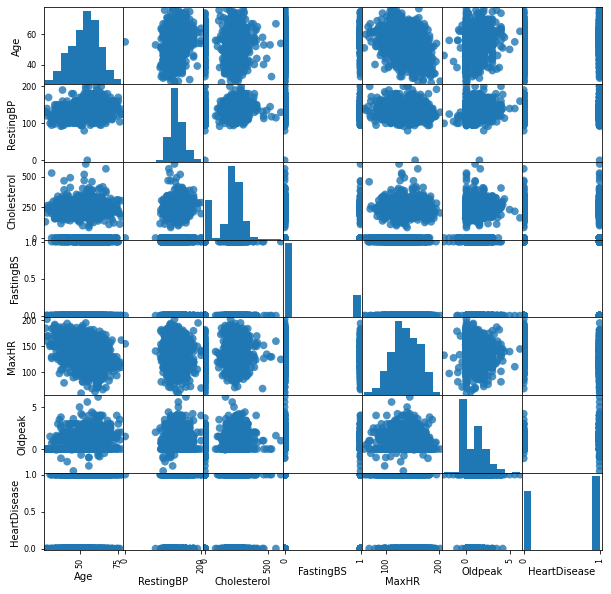

In [41]:
heart_pair_plot = pd.plotting.scatter_matrix(heart_df, figsize=(10,10), marker = 'o', hist_kwds = {'bins': 10}, s = 60, alpha = 0.8)
plt.show()

In [42]:
heart_df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


<AxesSubplot:>

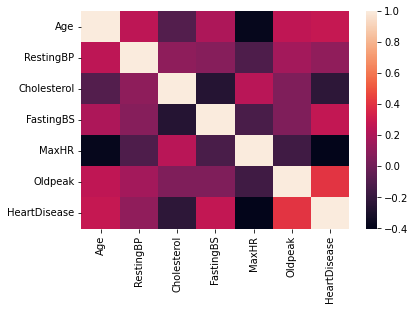

In [43]:
correlations = heart_df.corr()
sns.heatmap(correlations)

2. Use Principal Components Analysis for Feature Selection

In [44]:
#Convert categorical data into numeric data types by using get_dummies()

heart_train_dummies_df = pd.get_dummies(heart_train_df, columns=['Sex', 'ChestPainType','RestingECG', 'ST_Slope', 'ExerciseAngina'])
heart_train_dummies_df = heart_train_dummies_df.drop('HeartDisease', axis=1)

heart_test_dummies_df = pd.get_dummies(heart_test_df, columns=['Sex', 'ChestPainType','RestingECG', 'ST_Slope', 'ExerciseAngina'])
heart_test_dummies_df = heart_test_dummies_df.drop('HeartDisease', axis=1)

heart_train_dummies_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_N,ExerciseAngina_Y
0,66,146,278,0,152,0.0,1,0,0,0,1,0,1,0,0,0,1,0,1,0
1,65,150,235,0,120,1.5,0,1,1,0,0,0,0,1,0,0,1,0,0,1
2,63,150,223,0,115,0.0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
3,58,136,164,0,99,2.0,0,1,0,1,0,0,0,0,1,0,1,0,0,1
4,54,192,283,0,195,0.0,0,1,0,1,0,0,1,0,0,0,0,1,1,0


In [45]:
# Normalize the data in standardized form
train_scaler=StandardScaler()
scaled_heart_train = heart_train_dummies_df.copy()
scaled_heart_train = pd.DataFrame(train_scaler.fit_transform(scaled_heart_train), columns=scaled_heart_train.columns)

test_scaler=StandardScaler()
scaled_heart_test = heart_test_dummies_df.copy()
scaled_heart_test = pd.DataFrame(test_scaler.fit_transform(scaled_heart_test), columns=scaled_heart_test.columns)

scaled_heart_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_N,ExerciseAngina_Y
0,1.350090,0.733764,0.752404,-0.5677,0.610516,-0.820203,2.005238,-2.005238,-1.087369,-0.483401,1.913724,-0.239661,1.996525,-1.247061,-0.485593,-0.279425,0.988919,-0.854471,0.820768,-0.820768
1,1.243824,0.949418,0.360692,-0.5677,-0.666892,0.566545,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661,-0.500870,0.801886,-0.485593,-0.279425,0.988919,-0.854471,-1.218371,1.218371
2,1.031290,0.949418,0.251377,-0.5677,-0.866487,-0.820203,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661,-0.500870,0.801886,-0.485593,-0.279425,0.988919,-0.854471,0.820768,-0.820768
3,0.499957,0.194629,-0.286089,-0.5677,-1.505191,1.028795,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661,-0.500870,-1.247061,2.059339,-0.279425,0.988919,-0.854471,-1.218371,1.218371
4,0.074890,3.213783,0.797952,-0.5677,2.327033,-0.820203,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661,1.996525,-1.247061,-0.485593,-0.279425,-1.011205,1.170315,0.820768,-0.820768


In [46]:
# Apply PCA() to the training data set
pca_train = PCA(n_components=scaled_heart_train.shape[1])
components_train = pca_train.fit_transform(scaled_heart_train)
scaled_heart_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_N,ExerciseAngina_Y
0,1.350090,0.733764,0.752404,-0.5677,0.610516,-0.820203,2.005238,-2.005238,-1.087369,-0.483401,1.913724,-0.239661,1.996525,-1.247061,-0.485593,-0.279425,0.988919,-0.854471,0.820768,-0.820768
1,1.243824,0.949418,0.360692,-0.5677,-0.666892,0.566545,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661,-0.500870,0.801886,-0.485593,-0.279425,0.988919,-0.854471,-1.218371,1.218371
2,1.031290,0.949418,0.251377,-0.5677,-0.866487,-0.820203,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661,-0.500870,0.801886,-0.485593,-0.279425,0.988919,-0.854471,0.820768,-0.820768
3,0.499957,0.194629,-0.286089,-0.5677,-1.505191,1.028795,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661,-0.500870,-1.247061,2.059339,-0.279425,0.988919,-0.854471,-1.218371,1.218371
4,0.074890,3.213783,0.797952,-0.5677,2.327033,-0.820203,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661,1.996525,-1.247061,-0.485593,-0.279425,-1.011205,1.170315,0.820768,-0.820768


In [47]:
# Apply PCA() to the test data set
pca_test = PCA(n_components=scaled_heart_test.shape[1])
components_test = pca_test.fit_transform(scaled_heart_test)
scaled_heart_test.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_N,ExerciseAngina_Y
0,0.710696,-0.131919,-1.975347,2.031798,-2.244199,1.599685,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445,-0.531085,0.859727,-0.507801,-0.241249,1.030464,-0.922958,0.833616,-0.833616
1,-1.511883,1.067345,0.112490,-0.492175,1.634111,-0.881216,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445,-0.531085,0.859727,-0.507801,-0.241249,-0.970437,1.083473,0.833616,-0.833616
2,-0.982698,-0.131919,0.075040,-0.492175,-0.267753,0.111144,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445,-0.531085,-1.163160,1.969276,-0.241249,1.030464,-0.922958,-1.199593,1.199593
3,0.816533,1.394417,-0.383722,-0.492175,0.030579,-0.881216,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445,-0.531085,-1.163160,1.969276,-0.241249,1.030464,-0.922958,-1.199593,1.199593
4,0.604859,-0.131919,-0.046672,-0.492175,-0.193170,1.500449,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445,1.882938,-1.163160,-0.507801,-0.241249,1.030464,-0.922958,-1.199593,1.199593


Last 5 features are not shown in the scree plot since they're close to zero thus have no significant signals as 
principal components. The features that could be excluded are'ST_Slope' and 'ExerciseAngina'

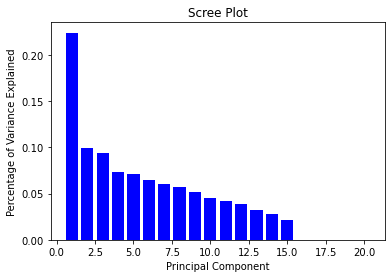

In [48]:
singular_values = np.arange(pca_train.n_components_) + 1
plt.bar(singular_values, pca_train.explained_variance_ratio_, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.show()

Further reducing the dimensionality to keep the variance percentage to 90% since the last 8 principal components only account for approximately 5% of the total variances that carry the least imporatant information, excluded features are therefore RestingECG_LVH, RestingECG_Normal, RestingECG_ST, ST_Slope_Down, ST_Slope_Flat, ST_Slope_Up, ExerciseAngina_N and ExerciseAngina_Y.

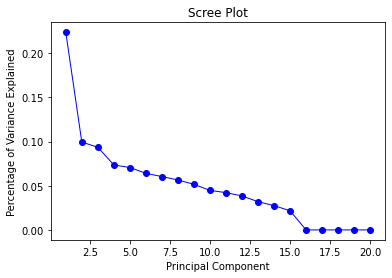

In [49]:
plt.plot(singular_values, pca_train.explained_variance_ratio_, '-o', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.show()

In [50]:
# The last 8 principal components only account for 5% of the total variances, these principal components can be eliminated.
accumulative_variance_percent = np.cumsum(pca_train.explained_variance_ratio_)  
accumulative_variance_percent

array([0.22373241, 0.32316039, 0.41672064, 0.49027509, 0.56089759,
       0.62498389, 0.68532719, 0.74187698, 0.7934767 , 0.83821301,
       0.88039294, 0.91887263, 0.95082033, 0.97831834, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [51]:
# Both subset of sex and chestpaintype columns account for 10% and 13%, these are kept in the data set.
# Oldpeak only accounts for 5.6% of the total variances, it can be eliminated while keeping a PCA 
# variance ratio at approximately 85%.
pca_train.explained_variance_ratio_

array([2.23732411e-01, 9.94279757e-02, 9.35602575e-02, 7.35544441e-02,
       7.06225006e-02, 6.40862976e-02, 6.03433054e-02, 5.65497925e-02,
       5.15997143e-02, 4.47363140e-02, 4.21799322e-02, 3.84796871e-02,
       3.19476956e-02, 2.74980082e-02, 2.16816645e-02, 7.09144270e-33,
       4.79677972e-33, 2.02538249e-33, 8.42106497e-34, 7.09683647e-34])

In [63]:
#The final processed training data set include features from Age to ChestPainType_TA and HeartDisease as the target class. 
processed_train_df = scaled_heart_train.loc[:, 'Age':'ChestPainType_TA']
# processed_train_df = processed_train_df.drop('Oldpeak', axis=1)
target_train = heart_train_df['HeartDisease']
processed_train_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,1.350090,0.733764,0.752404,-0.5677,0.610516,-0.820203,2.005238,-2.005238,-1.087369,-0.483401,1.913724,-0.239661
1,1.243824,0.949418,0.360692,-0.5677,-0.666892,0.566545,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661
2,1.031290,0.949418,0.251377,-0.5677,-0.866487,-0.820203,-0.498694,0.498694,0.919651,-0.483401,-0.522542,-0.239661
3,0.499957,0.194629,-0.286089,-0.5677,-1.505191,1.028795,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661
4,0.074890,3.213783,0.797952,-0.5677,2.327033,-0.820203,-0.498694,0.498694,-1.087369,2.068674,-0.522542,-0.239661


In [64]:
#The final processed test data set include features from Age to ChestPainType_TA and HeartDisease as the target class.
processed_test_df = scaled_heart_test.loc[:, 'Age':'ChestPainType_TA']
# processed_test_df = processed_test_df.drop('Oldpeak', axis=1)
target_test = heart_test_df['HeartDisease']
processed_test_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,0.710696,-0.131919,-1.975347,2.031798,-2.244199,1.599685,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445
1,-1.511883,1.067345,0.112490,-0.492175,1.634111,-0.881216,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445
2,-0.982698,-0.131919,0.075040,-0.492175,-0.267753,0.111144,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445
3,0.816533,1.394417,-0.383722,-0.492175,0.030579,-0.881216,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445
4,0.604859,-0.131919,-0.046672,-0.492175,-0.193170,1.500449,-0.57735,0.57735,0.932287,-0.476439,-0.569652,-0.190445


In [38]:
# Use mutual information to select features --> eliminate ChestPainType_TA, ChestPainType_NAP, and RestingBP 
# --> the accuracy score results in lower value than processed data set thus not used.
# mutual_info = mutual_info_classif(processed_train_df, target_train)
# mutual_info = pd.Series(mutual_info)
# mutual_info.index = processed_train_df.columns
# mutual_info.sort_values(ascending=False)
# final_processed_train_df = processed_train_df.drop(['ChestPainType_TA', 'ChestPainType_NAP', 'RestingBP'], axis=1)
# final_processed_test_df = processed_test_df.drop(['ChestPainType_TA', 'ChestPainType_NAP', 'RestingBP'], axis=1)


In [65]:
# Using polynomial features to derive alternative features in training data
# --> the accuracy score results in lower value than processed data set. 
# Accuracy result is shown in the Logistic Regression Model as 0.795 < 0.83 if using pf_train_data with polynomial features
poly_features_train = PolynomialFeatures(degree=2, interaction_only=True)
pf_train_data = poly_features_train.fit_transform(processed_train_df)
pf_train_df = pd.DataFrame(pf_train_data)
pf_train_df.head()

# Using polynomial features to derive alternative features in test data
poly_features_test = PolynomialFeatures(degree=2, interaction_only=True)
pf_test_data = poly_features_test.fit_transform(processed_test_df)
pf_test_df = pd.DataFrame(pf_test_data)
pf_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,1.0,0.710696,-0.131919,-1.975347,2.031798,-2.244199,1.599685,-0.57735,0.57735,0.932287,...,0.538256,-0.275072,-0.328889,-0.109954,-0.444178,-0.531079,-0.17755,0.271404,0.090736,0.108488
1,1.0,-1.511883,1.067345,0.112490,-0.492175,1.634111,-0.881216,-0.57735,0.57735,0.932287,...,0.538256,-0.275072,-0.328889,-0.109954,-0.444178,-0.531079,-0.17755,0.271404,0.090736,0.108488
2,1.0,-0.982698,-0.131919,0.075040,-0.492175,-0.267753,0.111144,-0.57735,0.57735,0.932287,...,0.538256,-0.275072,-0.328889,-0.109954,-0.444178,-0.531079,-0.17755,0.271404,0.090736,0.108488
3,1.0,0.816533,1.394417,-0.383722,-0.492175,0.030579,-0.881216,-0.57735,0.57735,0.932287,...,0.538256,-0.275072,-0.328889,-0.109954,-0.444178,-0.531079,-0.17755,0.271404,0.090736,0.108488
4,1.0,0.604859,-0.131919,-0.046672,-0.492175,-0.193170,1.500449,-0.57735,0.57735,0.932287,...,0.538256,-0.275072,-0.328889,-0.109954,-0.444178,-0.531079,-0.17755,0.271404,0.090736,0.108488


## Task 2. Classification + Iterations  + Evaluation Methods

In [167]:
#Input actual result and predictions
#Output confusion matrix

def calculate_confusion_matrix(actual, predicted):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for a_val, p_val in zip(actual, predicted):
        if a_val == p_val:
            if a_val == 1.0:
                tp += 1
            else:
                tn += 1
        else:
            if a_val == 1.0:
                fp += 1
            else:
                fn += 1
    confusion_matrix = [
        [tp, fp],
        [fn, tn]
    ]
    confusion_matrix = np.array(confusion_matrix)

    
    return confusion_matrix


#### 1. Logistic Regression Model

In [177]:
#1.1 Classification Method: Using Logistic Regression Model on processed data set: accuracy = 0.83
LR_classifier1 = LogisticRegression()
LR_classifier1.fit(processed_train_df, target_train)
LR_test_predictions1 = LR_classifier1.predict(processed_test_df)
LR_accuracy1 = accuracy_score(target_test, LR_test_predictions1)
parameters1 = LR_classifier1.coef_
print(LR_accuracy1)
# print(parameters1)

#Calculate MSE, Bias, and Variance Values
LR1_mse, LR1_bias, LR1_var = bias_variance_decomp(LogisticRegression(), processed_train_df.values, target_train.values, processed_test_df.values, target_test.values, loss='mse', random_seed=1)
print("LR1_MSE: " + str(LR1_mse),"LR1_Bias: " + str(LR1_bias), "LR1_Variance: " + str(LR1_var))

#1.2 Classification Method: Using Logistic Regression Model on data set with polynomial features: accuracy = 0.795
LR_classifier = LogisticRegression()
LR_classifier.fit(pf_train_df, target_train)
LR_test_predictions = LR_classifier.predict(pf_test_df)
LR_accuracy = accuracy_score(target_test, LR_test_predictions)
parameters = LR_classifier.coef_
print(LR_accuracy)
# print(parameters)

#Calculate MSE, Bias, and Variance Values
LR2_mse, LR2_bias, LR2_var = bias_variance_decomp(LogisticRegression(), pf_train_df.values, target_train.values, pf_test_df.values, target_test.values, loss='mse', random_seed=1)
print("LR2_MSE: " + str(LR2_mse),"LR2_Bias: " + str(LR2_bias), "LR2_Variance: " + str(LR2_var))

0.83
LR1_MSE: 0.18567499999999998 LR1_Bias: 0.159239125 LR1_Variance: 0.026435874999999998
0.795
LR2_MSE: 0.21795 LR2_Bias: 0.1641975 LR2_Variance: 0.053752499999999995


In [105]:
# Making Improvements for Logistic Regression Models


# Preparing GridSearch for data set with polynomial features: accuracy score is improved from 0.795 to 0.816
parameters = {
    'penalty': ['l1','l2'], 
    'C': np.logspace(-3,3,7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
}

LR_for_ptuning = LogisticRegression()
GS = GridSearchCV(LR_for_ptuning,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

GS1 = GS.fit(pf_train_df, target_train)
GS1_predictions = GS1.predict(pf_test_df)

In [108]:
print("Hyperparameters for preprocessed data set with polynomial features:", GS1.best_params_)
print("Accuracy for preprocessed data set with polynomial features::",GS1.best_score_)

#Calculate F1 Value
print(classification_report(target_test, GS1_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(LR_for_ptuning, pf_train_df.values, target_train.values, pf_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
GS1_confusion_matrix = calculate_confusion_matrix(target_test, GS1_predictions)
GS1_confusion_matrix

Hyperparameters for preprocessed data set with polynomial features: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy for preprocessed data set with polynomial features:: 0.8118348982785604
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        95
           1       0.80      0.85      0.82       105

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

MSE: 0.21795 Bias: 0.1641975 Variance: 0.053752499999999995


array([[89, 16],
       [22, 73]])

In [178]:
# Preparing GridSearch for data set with NO polynomial features: accuracy score is decreased from 0.83 to 0.8118
GS2 = GS.fit(processed_train_df, target_train)
GS2_predictions = GS2.predict(processed_test_df)
print("Hyperparameters for preprocessed data set with NO polynomial features:", GS2.best_params_)
print("Accuracy for preprocessed data set with NO polynomial features::",GS2.best_score_)


#Calculate F1 Value
print(classification_report(target_test, GS2_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(LR_for_ptuning, processed_train_df.values, target_train.values, processed_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
GS2_confusion_matrix = calculate_confusion_matrix(target_test, GS2_predictions)
GS2_confusion_matrix

Hyperparameters for preprocessed data set with NO polynomial features: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy for preprocessed data set with NO polynomial features:: 0.8118348982785604
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        95
           1       0.81      0.84      0.83       105

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

MSE: 0.18567499999999998 Bias: 0.159239125 Variance: 0.026435874999999998


array([[88, 17],
       [20, 75]])

#### 2. Support Vector Machine Model

In [116]:
#2.1 Classification Method: Using Support Vector Machine Model on processed data set: accuracy = 0.82
SVM_classifier1 = SVC(kernel='linear')
SVM_classifier1.fit(processed_train_df, target_train)
SVM_test_predictions1 = SVM_classifier1.predict(processed_test_df)
SVM_accuracy1 = accuracy_score(target_test, SVM_test_predictions1)
# SVM_parameters = SVM_classifier.coef_
print(SVM_accuracy1)


#2.2 Classification Method: Using Support Vector Machine Model on data set with polynomial features: accuracy = 0.795
SVM_classifier2 = SVC(kernel='linear')
SVM_classifier2.fit(pf_train_df, target_train)
SVM_test_predictions2 = SVM_classifier2.predict(pf_test_df)
SVM_accuracy2 = accuracy_score(target_test, SVM_test_predictions2)
# SVM_parameters = SVM_classifier.coef_
print(SVM_accuracy2)

0.82
0.795


In [125]:
# Making Improvements for Support Vector Machine Models


# Preparing GridSearch for data set with polynomial features: accuracy score is improved from 0.795 to 0.809
SVM_parameters = {
    'C': [0.1,1, 10, 100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

SVM_for_ptuning = SVC()
SVM_GS = GridSearchCV(SVM_for_ptuning,                    # model
                   param_grid = SVM_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

SVM_GS1 = SVM_GS.fit(pf_train_df, target_train)
SVM_GS1_predictions = SVM_GS1.predict(pf_test_df)

In [126]:
print("Hyperparameters for preprocessed data set with polynomial features:", SVM_GS1.best_params_)
print("Accuracy for preprocessed data set with polynomial features::",SVM_GS1.best_score_)

#Calculate F1 Value
print(classification_report(target_test, SVM_GS1_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(SVM_for_ptuning, pf_train_df.values, target_train.values, pf_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
SVM_GS1_confusion_matrix = calculate_confusion_matrix(target_test, SVM_GS1_predictions)
SVM_GS1_confusion_matrix

Hyperparameters for preprocessed data set with polynomial features: {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}
Accuracy for preprocessed data set with polynomial features:: 0.8091549295774648
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        95
           1       0.76      0.87      0.81       105

    accuracy                           0.79       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

MSE: 0.20804999999999998 Bias: 0.1709475 Variance: 0.0371025


array([[91, 14],
       [28, 67]])

In [127]:
# Preparing GridSearch for data set with NO polynomial features: accuracy score is decreased from 0.82 to 0.8188
SVM_GS2 = SVM_GS.fit(processed_train_df, target_train)
SVM_GS2_predictions = SVM_GS2.predict(processed_test_df)
print("Hyperparameters for preprocessed data set with NO polynomial features:", SVM_GS2.best_params_)
print("Accuracy for preprocessed data set with NO polynomial features::",SVM_GS2.best_score_)


#Calculate F1 Value
print(classification_report(target_test, SVM_GS2_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(SVM_for_ptuning, pf_train_df.values, target_train.values, pf_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
SVM_GS2_confusion_matrix = calculate_confusion_matrix(target_test, SVM_GS2_predictions)
SVM_GS2_confusion_matrix

Hyperparameters for preprocessed data set with NO polynomial features: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy for preprocessed data set with NO polynomial features:: 0.8188184663536777
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        95
           1       0.81      0.88      0.84       105

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

MSE: 0.20804999999999998 Bias: 0.1709475 Variance: 0.0371025


array([[92, 13],
       [22, 73]])

#### 3. Decision Tree Model

In [135]:
heart_train_dummies_df = heart_train_dummies_df.loc[:, 'Age':'ChestPainType_TA']
heart_train_dummies_target = heart_train_df['HeartDisease']
heart_test_dummies_df = heart_test_dummies_df.loc[:, 'Age':'ChestPainType_TA']
heart_test_dummies_target = heart_test_df['HeartDisease']
heart_train_dummies_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,66,146,278,0,152,0.0,1,0,0,0,1,0
1,65,150,235,0,120,1.5,0,1,1,0,0,0
2,63,150,223,0,115,0.0,0,1,1,0,0,0
3,58,136,164,0,99,2.0,0,1,0,1,0,0
4,54,192,283,0,195,0.0,0,1,0,1,0,0


In [146]:
#3. Classification Method: Using Decision Tree Model
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(heart_train_dummies_df, heart_train_dummies_target)
DT_test_predictions = DT_classifier.predict(heart_test_dummies_df)
DT_accuracy = accuracy_score(heart_test_dummies_target, DT_test_predictions)
# DT_parameters = DT_classifier.coef_
print(DT_accuracy)
# print(DT_parameters)

0.705


In [147]:
# Making Improvements for Decision Tree Models


# Preparing GridSearch for data set with preprocessing data set: accuracy score is improved from 0.705 to 0.788
DT_parameters = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

DT_for_ptuning = DecisionTreeClassifier()
DT_GS = GridSearchCV(DT_for_ptuning,                    # model
                   param_grid = DT_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

DT_GS1 = DT_GS.fit(heart_train_dummies_df, heart_train_dummies_target)
DT_GS1_predictions = DT_GS1.predict(heart_test_dummies_df)

In [148]:
print("Hyperparameters for preprocessed data set with polynomial features:", DT_GS1.best_params_)
print("Accuracy for preprocessed data set with polynomial features::", DT_GS1.best_score_)

#Calculate F1 Value
print(classification_report(target_test, DT_GS1_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, heart_train_dummies_df.values, target_train.values, heart_test_dummies_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
DT_GS1_confusion_matrix = calculate_confusion_matrix(target_test, DT_GS1_predictions)
DT_GS1_confusion_matrix

Hyperparameters for preprocessed data set with polynomial features: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
Accuracy for preprocessed data set with polynomial features:: 0.7882237871674491
              precision    recall  f1-score   support

           0       0.75      0.76      0.75        95
           1       0.78      0.77      0.78       105

    accuracy                           0.77       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.77      0.77      0.77       200

MSE: 0.2826 Bias: 0.14286975 Variance: 0.13973025


array([[81, 24],
       [23, 72]])

#### 4. Classification Method: Random Forest Model

In [151]:
#4. Classification Method: Using Random Forest Model
RF_classifier = RandomForestClassifier()
RF_classifier.fit(heart_train_dummies_df, heart_train_dummies_target)
RF_test_predictions = RF_classifier.predict(heart_test_dummies_df)
RF_accuracy = accuracy_score(heart_test_dummies_target, DT_test_predictions)
print(RF_accuracy)

0.705


In [155]:
# Making Improvements for Random Forest Models


# Preparing GridSearch for data set with preprocessing data set: accuracy score is improved from 0.705 to 0.825
RF_parameters = {
    'n_estimators': [5, 15, 20],
    'max_depth': [5, 10, 15, 20, 25],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

RF_for_ptuning = RandomForestClassifier()
RF_GS = GridSearchCV(RF_for_ptuning,                    # model
                   param_grid = RF_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

RF_GS1 = RF_GS.fit(heart_train_dummies_df, heart_train_dummies_target)
RF_GS1_predictions = RF_GS1.predict(heart_test_dummies_df)

In [160]:
print("Hyperparameters for non-scaled data set with polynomial features:", RF_GS1.best_params_)
print("Accuracy for non-scaled data set with polynomial features::", RF_GS1.best_score_)

#Calculate F1 Value
print(classification_report(target_test, RF_GS1_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, heart_train_dummies_df.values, target_train.values, heart_test_dummies_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
RF_GS1_confusion_matrix = calculate_confusion_matrix(target_test, RF_GS1_predictions)
RF_GS1_confusion_matrix

Hyperparameters for non-scaled data set with polynomial features: {'bootstrap': True, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}
Accuracy for non-scaled data set with polynomial features:: 0.8258215962441315
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        95
           1       0.80      0.87      0.83       105

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

MSE: 0.28037500000000004 Bias: 0.140838125 Variance: 0.139536875


array([[91, 14],
       [23, 72]])

#### 5. Naive Bayes Model

In [164]:
#5. Classification Method: Using Naive Bayes Model
NB_classifier = GaussianNB()
NB_classifier.fit(processed_train_df, target_train)
NB_test_predictions = NB_classifier.predict(processed_test_df)
NB_accuracy = accuracy_score(target_test, NB_test_predictions)
# NB_parameters = NB_classifier.coef_
print(NB_accuracy)

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(NB_classifier, processed_train_df.values, target_train.values, processed_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
NB_confusion_matrix = calculate_confusion_matrix(target_test, NB_test_predictions)
print(NB_confusion_matrix)

#Calculate F1
precision = NB_confusion_matrix[0,0] / (NB_confusion_matrix[0,0]  + NB_confusion_matrix[0,1])
recall = NB_confusion_matrix[0,0] / (NB_confusion_matrix[0,0]  + NB_confusion_matrix[1,0])
f1 = 2 * (precision * recall) / (precision + recall)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)


0.79
MSE: 0.21610000000000004 Bias: 0.201316 Variance: 0.014784
[[88 17]
 [25 70]]
precision:  0.8380952380952381
recall:  0.7787610619469026
f1:  0.8073394495412844


In [165]:
#6. Classification Method: Using K Nearest Neighbor Model
KNN_classifier = KNeighborsClassifier()
KNN_classifier.fit(processed_train_df, target_train)
KNN_test_predictions = KNN_classifier.predict(processed_test_df)
KNN_accuracy = accuracy_score(target_test, KNN_test_predictions)
print(KNN_accuracy)

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(KNN_classifier, processed_train_df.values, target_train.values, processed_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
KNN_confusion_matrix = calculate_confusion_matrix(target_test, KNN_test_predictions)
print(KNN_confusion_matrix)

#Calculate F1
precision = KNN_confusion_matrix[0,0] / (KNN_confusion_matrix[0,0]  + KNN_confusion_matrix[0,1])
recall = KNN_confusion_matrix[0,0] / (KNN_confusion_matrix[0,0]  + KNN_confusion_matrix[1,0])
f1 = 2 * (precision * recall) / (precision + recall)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)


0.815
MSE: 0.21404999999999996 Bias: 0.1455605 Variance: 0.0684895
[[84 21]
 [16 79]]
precision:  0.8
recall:  0.84
f1:  0.8195121951219512


## Task 3. Evaluation
###### For convenience purpose, all the statistical evaluations and model implementations are grouped together in section 2. This section is a demonstration of ROC

#### 1. ROC for Logistic Regression Model

In [168]:
LR_confusion_matrix = calculate_confusion_matrix(target_test, LR_test_predictions)
LR_confusion_matrix

array([[88, 17],
       [24, 71]])

In [169]:
#1. Confusion Matrix for Logistic Regression Model
LR_confusion_matrix = calculate_confusion_matrix(target_test, LR_test_predictions)
precision = LR_confusion_matrix[0,0] / (LR_confusion_matrix[0,0]  + LR_confusion_matrix[0,1])
recall = LR_confusion_matrix[0,0] / (LR_confusion_matrix[0,0]  + LR_confusion_matrix[1,0])
f1 = 2 * (precision * recall) / (precision + recall)
mse, bias, var = bias_variance_decomp(LR_classifier, processed_train_df.values, target_train.values, processed_test_df.values, target_test.values, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))
LR_confusion_matrix

MSE: 0.18567499999999998 Bias: 0.159239125 Variance: 0.026435874999999998


array([[88, 17],
       [24, 71]])

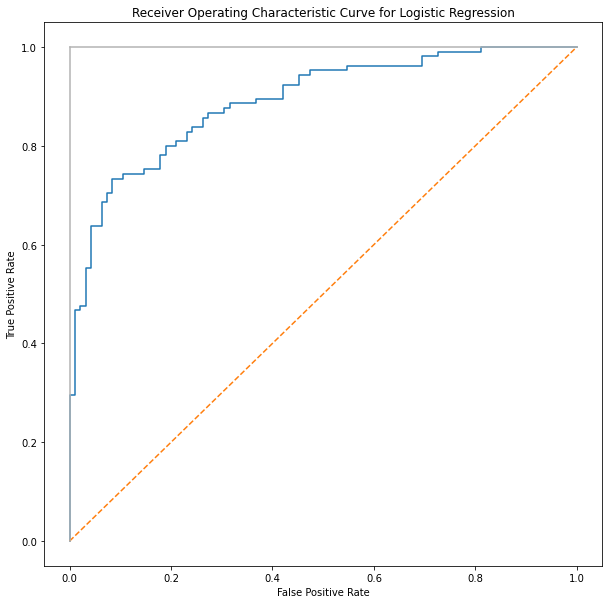

In [185]:
LR_predict_proba = LR_classifier.predict_proba(pf_test_df.values)[:,1]
LR_fpr,LR_tpr,LR_threshold = roc_curve(target_test,LR_predict_proba)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve for Logistic Regression')
plt.plot(LR_fpr, LR_tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [187]:
optimal_idex = np.argmax(LR_tpr - LR_fpr)
optimal_threshold = LR_threshold[optimal_idex]
print("The Optimal Threshold is ", optimal_threshold)

The Optimal Threshold is  0.7293222020557085


#### 2. ROC for KNN Model

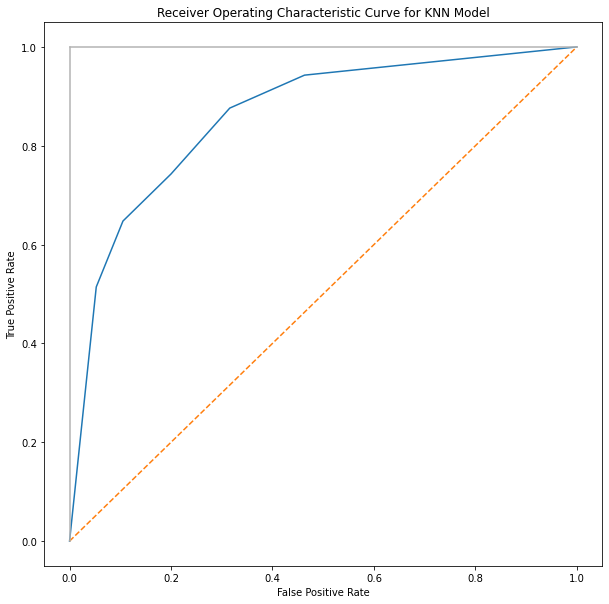

In [181]:
KNN_predict_proba = KNN_classifier.predict_proba(processed_test_df.values)[:,1]
KNN_fpr,KNN_tpr,KNN_threshold = roc_curve(target_test,KNN_predict_proba)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve for KNN Model')
plt.plot(KNN_fpr, KNN_tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [186]:
optimal_idex = np.argmax(KNN_tpr - KNN_fpr)
optimal_threshold = KNN_threshold[optimal_idex]
print("The Optimal Threshold is ", optimal_threshold)

The Optimal Threshold is  0.4
